In [1]:
import torch.nn as nn
import random
import torch
import torchvision
import numpy as np
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, Dataset
from torchsummary import summary
%matplotlib inline

In [2]:
from skimage.io import imread

In [3]:
#data_dir = "D:\Git\Research Paper\DataSet - Mehedi Hasan, Medical Technologist, Bangladesh Hospitals\Train"
#test_data_dir = "D:\Git\Research Paper\DataSet - Mehedi Hasan, Medical Technologist, Bangladesh Hospitals\Test"
normalize_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((150,150)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5, 0.5, 0.5), 
                                     std = (0.5, 0.5, 0.5))])

#dataset = ImageFolder(data_dir,transform = normalize_transform)
#test_dataset = ImageFolder(test_data_dir,transform= normalize_transform)

In [4]:
from skimage.io import imread

In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((150,150)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.Normalize(mean = (0.5, 0.5, 0.5), 
                                     std = (0.5, 0.5, 0.5))
])

#train2 = ImageFolder(data_dir,transform = transforms)

In [6]:
root = "D:\Git\Research Paper\DataSet - Mehedi Hasan, Medical Technologist, Bangladesh Hospitals\Project\Train"

In [7]:
dataset = ImageFolder(root,transform = transform)
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

In [8]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
#train_loader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=batch_size)
#test_loader2 = torch.utils.data.DataLoader(test_dataset2, batch_size=batch_size)

(-0.5, 755.5, 151.5, -0.5)

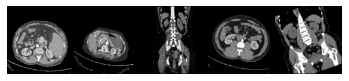

In [9]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
plt.imshow(np.transpose(torchvision.utils.make_grid(
  images[:5], normalize=True, padding=1, nrow=5).numpy(), (1, 2, 0)))
plt.axis('off')

In [10]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 150, 150]) 0


In [22]:
from torchvision.models import resnet50

In [23]:

#model = CNN().to(device)
resnet = resnet50(weights=None)
modules = list(resnet.children())[:-2]      # delete the last fc layer.
resnet.fc = nn.Linear(2048 , 2)

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [25]:
resnet = resnet.to(device)

In [26]:
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [52]:
summary(resnet, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           9,408
       BatchNorm2d-2           [-1, 64, 75, 75]             128
              ReLU-3           [-1, 64, 75, 75]               0
         MaxPool2d-4           [-1, 64, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]           4,096
       BatchNorm2d-6           [-1, 64, 38, 38]             128
              ReLU-7           [-1, 64, 38, 38]               0
            Conv2d-8           [-1, 64, 38, 38]          36,864
       BatchNorm2d-9           [-1, 64, 38, 38]             128
             ReLU-10           [-1, 64, 38, 38]               0
           Conv2d-11          [-1, 256, 38, 38]          16,384
      BatchNorm2d-12          [-1, 256, 38, 38]             512
           Conv2d-13          [-1, 256, 38, 38]          16,384
      BatchNorm2d-14          [-1, 256,

In [27]:

#Defining the model hyper parameters
num_epochs = 100
learning_rate = 0.00001
weight_decay = 0.001
weights = torch.Tensor([0.4, 0.6])
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss(size_average=True)
criterion.to(device)
#criterion = torch.nn.BCELoss(weight=weights)
optimizer = torch.optim.Adagrad(resnet.parameters(), lr=learning_rate, weight_decay=weight_decay)

d:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [28]:
def trainmodel(model, num_epochs, train_loader, valid_loader, criterion, optimizer):
    train_correct = 0
    train_total = 0
    valid_correct = 0
    valid_total = 0
    train_loss_list = []
    valid_loss_list = []
    train_accuracy_list = []
    valid_accuracy_list = []
    for epoch in range(num_epochs):
        train_loss = 0
        #model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            y_true = labels.to(device)
  
            outputs = model(images)
            labels = F.one_hot(labels, num_classes=2)
            loss = criterion(F.sigmoid(outputs), labels.float())
  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() 
            _, predicted = torch.max(outputs.data, 1)
            train_total += y_true.size(0)
            train_correct += (predicted == y_true).sum().item()

        #Accuracy
        train_loss_list.append(train_loss/len(train_loader))
        train_accuracy = 100 * train_correct / train_total
        train_accuracy_list.append(train_accuracy)

        valid_loss = 0.0
        for i, (images, labels) in enumerate(valid_loader):
            images = images.to(device)
            labels = labels.to(device)
            y_true = labels.to(device)
  
            outputs = model(images)
            labels = F.one_hot(labels, num_classes=2)
            loss = criterion(F.sigmoid(outputs), labels.float())
            valid_loss += loss.item() 
            _, predicted = torch.max(outputs.data, 1)
            valid_total += y_true.size(0)
            valid_correct += (predicted == y_true).sum().item()
        valid_loss_list.append(valid_loss/len(valid_loader))
        valid_accuracy = 100 * valid_correct / valid_total
        valid_accuracy_list.append(valid_accuracy)

        print("Epoch {}/{}, Train Loss: {:.3f}, Train Accuracy: {:.3f}, Validation Loss: {:.3f}, Validation Accuracy: {:.3f}".format(epoch+1,num_epochs, train_loss_list[-1], train_accuracy, valid_loss_list[-1], valid_accuracy))
    #plt.plot(range(1,num_epochs+1), train_loss_list)
    #plt.xlabel("Number of epochs")
    #plt.ylabel("Training loss")
    plt.plot(range(1,num_epochs+1), train_loss_list, 'bo', label='Training loss')
    plt.plot(range(1,num_epochs+1), valid_loss_list, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    plt.plot(range(1,num_epochs+1), train_accuracy_list, 'b', label='Training Accuracy')
    plt.plot(range(1,num_epochs+1), valid_accuracy_list, 'b', label='Validation Accuracy')
    plt.title('Training and validation Accuracy')
    plt.legend()
    plt.show()
    return 

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

d:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1/45, Train Loss: 0.574, Train Accuracy: 73.390, Validation Loss: 0.681, Validation Accuracy: 57.714
Epoch 2/45, Train Loss: 0.504, Train Accuracy: 73.966, Validation Loss: 0.606, Validation Accuracy: 63.337
Epoch 3/45, Train Loss: 0.473, Train Accuracy: 74.737, Validation Loss: 0.556, Validation Accuracy: 66.564
Epoch 4/45, Train Loss: 0.445, Train Accuracy: 75.742, Validation Loss: 0.541, Validation Accuracy: 68.009
Epoch 5/45, Train Loss: 0.425, Train Accuracy: 76.640, Validation Loss: 0.523, Validation Accuracy: 68.838
Epoch 6/45, Train Loss: 0.408, Train Accuracy: 77.433, Validation Loss: 0.517, Validation Accuracy: 69.473
Epoch 7/45, Train Loss: 0.395, Train Accuracy: 78.056, Validation Loss: 0.488, Validation Accuracy: 70.173
Epoch 8/45, Train Loss: 0.383, Train Accuracy: 78.666, Validation Loss: 0.468, Validation Accuracy: 70.913
Epoch 9/45, Train Loss: 0.375, Train Accuracy: 79.156, Validation Loss: 0.451, Validation Accuracy: 71.584
Epoch 10/45, Train Loss: 0.367, Train

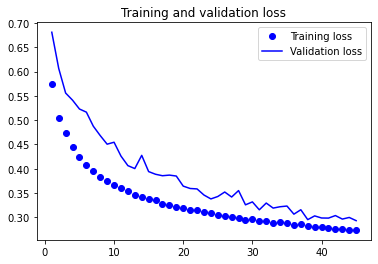

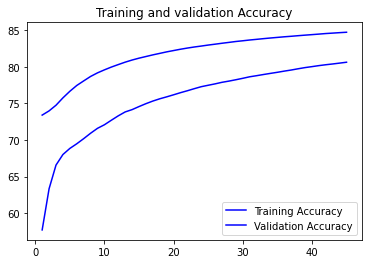

In [19]:
trainmodel(resnet, num_epochs, train_loader, valid_loader, criterion, optimizer)

In [12]:
def testmodel(model, loader):
    test_acc=0
    model.eval()
  
    with torch.no_grad():
        #Iterating over the training dataset in batches
        for i, (images, labels) in enumerate(loader):
          
            images = images.to(device)
            y_true = labels.to(device)
          
            #Calculating outputs for the batch being iterated
            outputs = model(images)
          
            #Calculated prediction labels from models
            _, y_pred = torch.max(outputs.data, 1)

            #Comparing predicted and true labels
            test_acc += (y_pred == y_true).sum().item()
      
        print(f"Test set accuracy = {100 * test_acc / len(valid_dataset)} %")

In [31]:
testmodel(resnet, valid_loader)

Test set accuracy = 85.98647818070067 %


In [32]:
torch.save(resnet.state_dict(), 'resnet50.pth')

In [22]:
fname = 'D:\\Git\\Research Paper\\Research_Project\\resnet50.pth'
loaded_dict = torch.load(fname)
resnet.load_state_dict(loaded_dict)

<All keys matched successfully>

In [56]:
def predict_img_class(img,model):
    """ Predict the class of image and Return Predicted Class"""
    img = img.to(device)
    prediction =  model(img.unsqueeze(0))
    _, preds = torch.max(prediction, dim = 1)
    return dataset.classes[preds[0].item()]

In [54]:
def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class : Stone


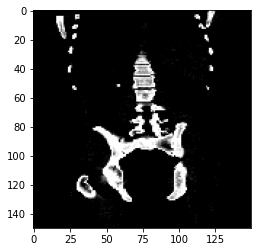

In [58]:
from PIL import Image
import cv2

#open image file
img_path = "D:\Git\Research Paper\DataSet - Mehedi Hasan, Medical Technologist, Bangladesh Hospitals\PredictorImg\8.png"
img = cv2.imread(img_path) 
#convert image to tensor
img = transform(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,resnet)}")

In [1]:
import cv2
import numpy as np
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
from PIL import Image
import matplotlib.pyplot as plt
import argparse

In [2]:
img_path = r"D:\Git\Research Paper\DataSet - Mehedi Hasan, Medical Technologist, Bangladesh Hospitals\PredictorImg\12.png"
img = cv2.imread(img_path, 0) 

In [3]:
img.shape

(1238, 1110)

In [4]:
roi = cv2.selectROI(img)
print(roi)
roi_cropped = img[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]   
cv2.imshow("ROI", roi_cropped)
cv2.waitKey(0)

(187, 264, 718, 249)


-1

In [5]:
roi_cropped.shape

(249, 718)

In [6]:
def build_filters():
    #returns a list of kernels in several orientations
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 32):
        params = {'ksize': (ksize, ksize), 'sigma': 0.0225, 'theta': theta, 'lambd': 15.0,
                  'gamma': 0.01, 'psi': 0, 'ktype': cv2.CV_32F}
        
        kern = cv2.getGaborKernel(**params)
        kern /= 1.5*kern.sum()
        filters.append((kern, params))
    return filters

In [7]:
def process(img, filters):
    #returns the img filtered by the filter list
    accum = np.zeros_like(img)
    for kern, params in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

In [8]:
def Histeq(img):
    equ = cv2.equalizeHist(img)
    return equ

def GaborFilter(img):
    filters = build_filters()
    p = process(img, filters)
    return p

In [9]:
def Laplacian(img,par):  
    lap = cv2.Laplacian(img,cv2.CV_64F)
    sharp = img - par*lap
    sharp = np.uint8(cv2.normalize(sharp, None, 0 , 255, cv2.NORM_MINMAX))
    return sharp

In [10]:
def Watershed(img):
    ret, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.23*dist_transform.max(),255,0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1

    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    img2 = roi_cropped
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    img2 = cv2.medianBlur(img2,5)
    markers = cv2.watershed(img2,markers)
    img2[markers == -1] = [255,0,0]
    print(img2.shape)

    return img2

In [11]:
img3 = GaborFilter(roi_cropped)
img3 = Histeq(img3)

In [12]:
img3.shape

(249, 718)

In [13]:
img3 = Laplacian(roi_cropped,0.423)

(249, 718, 3)


(([], []), ([], []))

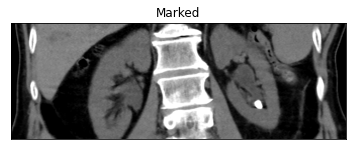

In [14]:
img3 = Watershed(img3)

plt.imshow(roi_cropped,'gray')
plt.title('Marked')
plt.xticks([]),plt.yticks([])

In [15]:
from scipy.signal import convolve2d
import os
import argparse


In [16]:
def get_mean_image_in_window(image, kernel):
    '''Get image consisting of mean values ​​of neighboring pixels in a window '''    
    neighbor_sum = convolve2d(
        image, kernel, mode='same',
        boundary='fill', fillvalue=0)

    num_neighbor = convolve2d(
        np.ones(image.shape), kernel, mode='same',
        boundary='fill', fillvalue=0)

    return neighbor_sum / num_neighbor     

In [17]:
class FCM():
    def __init__(self, image, image_bit, n_clusters, m, epsilon, max_iter):
        '''Modified Fuzzy C-means clustering
        <image>: 2D array, grey scale image.
        <n_clusters>: int, number of clusters/segments to create.
        <m>: float > 1, fuzziness parameter. A large <m> results in smaller
             membership values and fuzzier clusters. Commonly set to 2.
        <max_iter>: int, max number of iterations.
        '''

        #-------------------Check inputs-------------------
        if np.ndim(image) != 2:
            raise Exception("<image> needs to be 2D (gray scale image).")
        if n_clusters <= 0 or n_clusters != int(n_clusters):
            raise Exception("<n_clusters> needs to be positive integer.")
        if m < 1:
            raise Exception("<m> needs to be >= 1.")
        if epsilon <= 0:
            raise Exception("<epsilon> needs to be > 0")

        self.image = image
        self.image_bit = image_bit
        self.n_clusters = n_clusters
        self.m = m
        self.epsilon = epsilon
        self.max_iter = max_iter

        self.shape = image.shape # image shape
        self.X = image.flatten().astype('float') # flatted image shape: (number of pixels,1) 
        self.numPixels = image.size
       
    #--------------------------------------------- 
    def initial_U(self):
        U=np.zeros((self.numPixels, self.n_clusters))
        idx = np.arange(self.numPixels)
        for ii in range(self.n_clusters):
            idxii = idx%self.n_clusters==ii
            U[idxii,ii] = 1        
        return U
    
    def update_U(self):
        '''Compute weights'''
        c_mesh,idx_mesh = np.meshgrid(self.C,self.X)
        power = 2./(self.m-1)
        p1 = abs(idx_mesh-c_mesh)**power
        p2 = np.sum((1./abs(idx_mesh-c_mesh))**power,axis=1)
        
        return 1./(p1*p2[:,None])

    def update_C(self):
        '''Compute centroid of clusters'''
        numerator = np.dot(self.X,self.U**self.m)
        denominator = np.sum(self.U**self.m,axis=0)
        return numerator/denominator
                       
    def form_clusters(self):      
        '''Iterative training'''        
        d = 100
        self.U = self.initial_U()
        if self.max_iter != -1:
            i = 0
            while True:             
                self.C = self.update_C()
                old_u = np.copy(self.U)
                self.U = self.update_U()
                d = np.sum(abs(self.U - old_u))
                print("Iteration %d : cost = %f" %(i, d))

                if d < self.epsilon or i > self.max_iter:
                    break
                i+=1
        else:
            i = 0
            while d > self.epsilon:
                self.C = self.update_C()
                old_u = np.copy(self.U)
                self.U = self.update_U()
                d = np.sum(abs(self.U - old_u))
                print("Iteration %d : cost = %f" %(i, d))

                if d < self.epsilon or i > self.max_iter:
                    break
                i+=1
        self.segmentImage()


    def deFuzzify(self):
        return np.argmax(self.U, axis = 1)

    def segmentImage(self):
        '''Segment image based on max weights'''

        result = self.deFuzzify()
        self.result = result.reshape(self.shape).astype('int')

        return self.result

In [177]:
testimg = img3.transpose(2,0,1).reshape(-1,img3.shape[1])

In [172]:
img3.shape

(998, 1034, 3)

In [28]:
cluster = FCM(roi_cropped, image_bit=8, n_clusters=3, m=5, epsilon=0.05, max_iter=100)
cluster.form_clusters()
result=cluster.result

Iteration 0 : cost = 238374.995326
Iteration 1 : cost = 66.911050
Iteration 2 : cost = 153.443221
Iteration 3 : cost = 360.388412
Iteration 4 : cost = 319.615001
Iteration 5 : cost = 746.491958
Iteration 6 : cost = 1695.511162
Iteration 7 : cost = 4170.172414
Iteration 8 : cost = 7348.119041
Iteration 9 : cost = 11646.744037
Iteration 10 : cost = 17541.995242
Iteration 11 : cost = 19132.741940
Iteration 12 : cost = 17207.942302
Iteration 13 : cost = 16326.242422
Iteration 14 : cost = 15262.517303
Iteration 15 : cost = 16479.080697
Iteration 16 : cost = 17214.676384
Iteration 17 : cost = 17460.520643
Iteration 18 : cost = 16779.171570
Iteration 19 : cost = 16241.480361
Iteration 20 : cost = 14866.802360
Iteration 21 : cost = 13775.079625
Iteration 22 : cost = 12456.923573
Iteration 23 : cost = 11173.831867
Iteration 24 : cost = 8961.923053
Iteration 25 : cost = 8294.592853
Iteration 26 : cost = 7369.558335
Iteration 27 : cost = 6782.465013
Iteration 28 : cost = 5803.403512
Iteration 29 

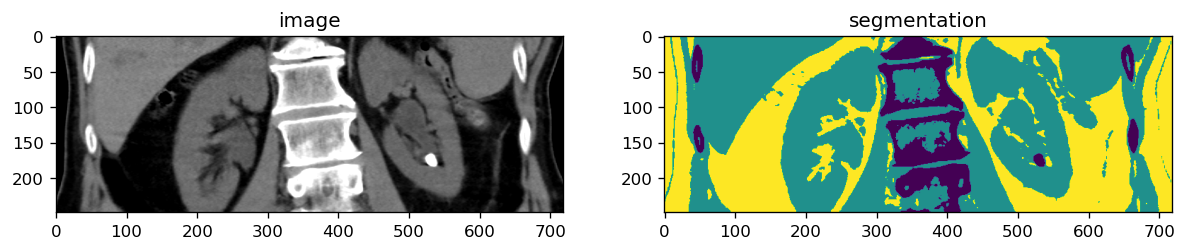

In [29]:
fig=plt.figure(figsize=(12,8),dpi=120)
            
ax1=fig.add_subplot(1,2,1)
ax1.imshow(roi_cropped,cmap='gray')
ax1.set_title('image')
ax2=fig.add_subplot(1,2,2)
ax2.imshow(result)
ax2.set_title('segmentation')
                
plt.show(block=False)
plt.close()

In [23]:
from sklearn.cluster import KMeans

In [153]:
img_path = r"D:\Git\Research Paper\DataSet - Mehedi Hasan, Medical Technologist, Bangladesh Hospitals\PredictorImg\11.png"
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED) 

In [26]:
#vectorized = img.reshape((-1,3))
kmeans = KMeans(n_clusters=249, random_state = 0, n_init=100).fit(roi_cropped)
centers = np.uint8(kmeans.cluster_centers_)
segmented_data = centers[kmeans.labels_.flatten()]
 
segmented_image = segmented_data.reshape((roi_cropped.shape))


d:\Anaconda\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0.5, 1.0, 'segmentation')

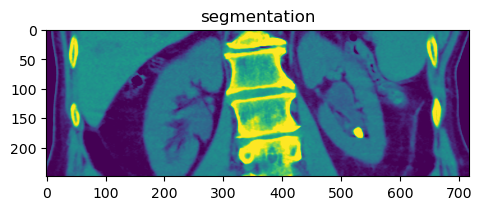

In [27]:

fig=plt.figure(figsize=(12,8),dpi=100)
ax1=fig.add_subplot(1,2,2)
ax1.imshow(segmented_image)
ax1.set_title('segmentation')